# COMP 5318 Assignment 1 - Group 136 Qianyi Wang

# 1. Load the data

In [1]:
import pandas as pd
import numpy as np
import os
print(os.listdir("./Input/train"))
pd.set_option('display.max_columns', 10)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
np.random.seed(42)

['train.csv']


In [2]:
#read train dataset including feature and label and build into pandas dataframe
data_train_df = pd.read_csv('./Input/train/train.csv')

In [3]:
#Reshape train set features data to numpy array
data_train_feature = data_train_df.loc[:, "v1":"v784"].to_numpy()

# Selecting output lable 
data_train_label = data_train_df.label.to_numpy()

In [4]:
#read test dataset including feature and build into pandas dataframe
data_test_df = pd.read_csv('./Input/test/test_input.csv', index_col=0) 

In [5]:
#rename feature train data to X_train
X_train = data_train_feature
#rename label train data to y_train
y_train = data_train_label
#Reshape test set to numpy array
X_test = data_test_df.loc[:,:].to_numpy()

# 2. Preprocessing the data

In [6]:
#inspect the scale of the dataset, which is [0,255]
print(np.nanmin(X_train))
print(np.nanmax(X_train))

0
255


In [7]:
#Adopting MinMaxSclaer to scale all data range to [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(X_train)

#transform train and test features dataset to new range 
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

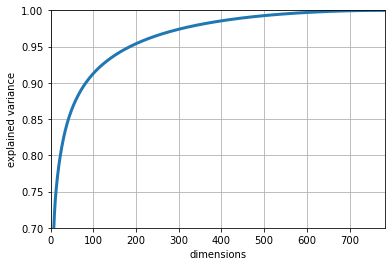

In [8]:
# Perform PCA without setting n_components
from sklearn.decomposition import PCA
pca = PCA()
#fit the feature train data under PCA
pca.fit(X_train_norm)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions

plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 784, 0.7, 1]) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

In [11]:
#choose n_components from the Elbow graph and fit and transform dataset
pca = PCA(n_components = 0.95)

#fit the train dataset under PCA rules
pca.fit(X_train_norm)

#transform pca scale to train and test features dataset
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [11]:
#check the new shape of train dataset
X_train_pca.shape


(30000, 187)

In [12]:
#check the new shape of test dataset
X_test_pca.shape

(5000, 187)

# 3.1 Classifier 1: KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#build parameter grid for gridsearch, parameters are number of neighbors and power parameters (p=1: manhattan_distance, p=2:eulidean_distance)
knn_param_grid = {'n_neighbors':[1,3,5,7,9,11,13,15], 'p':[1,2]}

#Fine-tune hyper-parameters using grid seaerch with KNeighborsClassifier, using 10-fold cross validation
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10)
knn_grid_search.fit(X_train_pca, y_train)

#print out the grid search cross-validation result as a dataframe
knn_gc_df = pd.DataFrame(knn_grid_search.cv_results_)
knn_gc_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015978,0.001630,10.684230,0.370504,1,...,0.846000,0.836000,0.841900,0.005348,15
1,0.015107,0.001008,0.710505,0.036539,1,...,0.846667,0.833333,0.838867,0.005031,16
2,0.015940,0.002264,10.781350,0.319002,3,...,0.845667,0.847333,0.848700,0.004183,9
3,0.015900,0.005517,0.804162,0.041500,3,...,0.848000,0.845667,0.848133,0.004886,10
4,0.017125,0.005212,11.264522,0.232042,5,...,0.852667,0.850333,0.853900,0.003836,1


In [14]:
#print out the best parameters combination
print("Best parameters: {}".format(knn_grid_search.best_params_))

Best parameters: {'n_neighbors': 5, 'p': 1}


In [15]:
#inspect the acccuracy and running time for each combination of the parameters
knn_accuracy = []
knn_running_time = []
m = 0
#use for loop to iterate all n_neighbors parameters 
for i in range(len(knn_param_grid['n_neighbors'])):
    mean_score = []
    mean_time = []
    #and nested another for loop to iterate p and to append the accuracy score and running time from each p type
    for j in range(len(knn_param_grid['p'])):
        mean_score.append(knn_grid_search.cv_results_['mean_test_score'][m]*100)
        mean_time.append(knn_grid_search.cv_results_['mean_fit_time'][m]
                        +knn_grid_search.cv_results_['mean_score_time'][m])
        m = m+1
    knn_accuracy.append(mean_score)
    knn_running_time.append(mean_time)
    
#transpose the accurracy and time array for ploting graph purpose       
knn_accuracy = np.array(knn_accuracy).T
knn_time = np.array(knn_running_time).T

In [16]:
#inspect the accuracy and running time for each combination in knn
print(knn_accuracy)
print(knn_time)

[[84.19       84.87       85.39       85.25666667 84.91333333 84.91
  84.77       84.75333333]
 [83.88666667 84.81333333 85.36666667 85.25666667 85.07666667 84.90333333
  84.80666667 84.68333333]]
[[10.70020769 10.79729087 11.28164682 11.20104938 12.35540848 11.00946934
  11.14647379 11.27864606]
 [ 0.72561216  0.82006226  1.24713306  1.18435676  1.19591763  1.19183128
   1.17224803  1.15683293]]


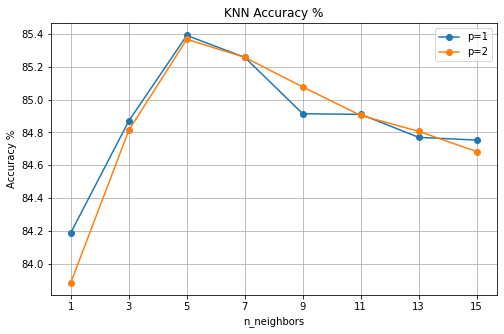

In [17]:
#plot the accuracy rate
plt.figure(figsize = (8,5))

plt.plot(knn_param_grid['n_neighbors'], knn_accuracy[0], marker='o')
plt.plot(knn_param_grid['n_neighbors'], knn_accuracy[1],  marker='o')
plt.xlabel('n_neighbors')
plt.ylabel(ylabel='Accuracy %')
plt.title('KNN Accuracy %')
plt.xticks(knn_param_grid['n_neighbors'])
plt.legend(["p=1", "p=2"])
plt.grid(True)

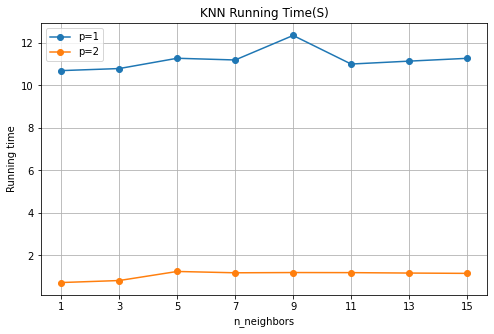

In [37]:
#plot the running time for each parameter combination
plt.figure(figsize = (8,5))

plt.plot(knn_param_grid['n_neighbors'], knn_time[0], marker='o')
plt.plot(knn_param_grid['n_neighbors'], knn_time[1],  marker='o')
plt.xlabel('n_neighbors')
plt.ylabel(ylabel='Running time')
plt.title('KNN Running Time(S)')
plt.xticks(knn_param_grid['n_neighbors'])
plt.legend(["p=1", "p=2"])
plt.grid(True)

In [18]:
#build the final model for knn with its best_parameters
knn = knn_grid_search.best_estimator_

# 3.2 Classifier: SVM

In [33]:
from sklearn.svm import SVC

#build parameter grid for SVM gridsearch, parameters are C for Regularization parameter and gamma for the Kernel coefficient.
svm_param_grid = {'C':[1, 10, 100, 1000],'gamma':[100,10,1,0.1,0.01,0.001]}

#Fine-tune hyper-parameters using grid search with SVC, using 10-fold cross validation
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=10)
svm_grid_search.fit(X_train_pca, y_train)

#print out the grid search cross-validation result as a dataframe
svm_gc_df = pd.DataFrame(svm_grid_search.cv_results_)
svm_gc_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,162.831563,4.722584,17.924176,0.333925,1,...,0.101333,0.101000,0.101333,0.000211,21
1,148.821099,2.835895,17.547748,0.245469,1,...,0.101667,0.102333,0.101933,0.000249,17
2,122.506199,4.033640,11.958182,0.114616,1,...,0.242667,0.246667,0.241567,0.007332,16
3,43.696176,0.583535,6.976158,0.033628,1,...,0.872333,0.868000,0.872867,0.005628,10
4,10.413048,0.067742,4.302614,0.015129,1,...,0.876000,0.877667,0.877333,0.004566,6


In [40]:
#print out the best parameters combination
print("Best parameters: {}".format(svm_grid_search.best_params_))

Best parameters: {'C': 10, 'gamma': 0.01}


In [41]:
#To inspect the accuracy and running time of each parameter combination
svm_accuracy = []
svm_running_time = []
m = 0
#use for loop to iterate all Cs parameters
for i in range(len(svm_param_grid['C'])):
    mean_score = []
    mean_time = []
    #and nested another for loop to iterate gamma and to append the accuracy score and running time from each p type
    for j in range(len(svm_param_grid['gamma'])):
        mean_score.append(svm_grid_search.cv_results_['mean_test_score'][m]*100)
        mean_time.append(svm_grid_search.cv_results_['mean_fit_time'][m]
                        +svm_grid_search.cv_results_['mean_score_time'][m])
        m = m+1
    svm_accuracy.append(mean_score)
    svm_running_time.append(mean_time)
        
svm_accuracy = np.array(svm_accuracy)
svm_time = np.array(svm_running_time)

In [42]:
#inspect the accuracy and running time for each combination in svm
print(svm_accuracy)
print(svm_running_time)

[[10.13333333 10.19333333 24.15666667 87.28666667 87.73333333 83.19      ]
 [10.13333333 10.19333333 27.02       87.66       89.25666667 86.42333333]
 [10.13333333 10.19333333 27.02       87.65666667 88.59333333 87.78666667]
 [10.13333333 10.19333333 27.02       87.65666667 88.24333333 88.20333333]]
[[180.7557389497757, 166.36884698867797, 134.46438117027282, 50.67233400344848, 14.715661573410033, 21.57393834590912], [177.6722942829132, 168.74343111515046, 130.73595006465914, 57.41524176597595, 13.923466014862061, 15.211276578903199], [178.72028515338897, 165.70423078536987, 130.68910660743714, 56.542134404182434, 15.048705101013184, 13.573767805099488], [180.79027116298676, 167.8081376791, 123.69354202747346, 53.63212304115296, 14.904073452949524, 17.027722692489625]]


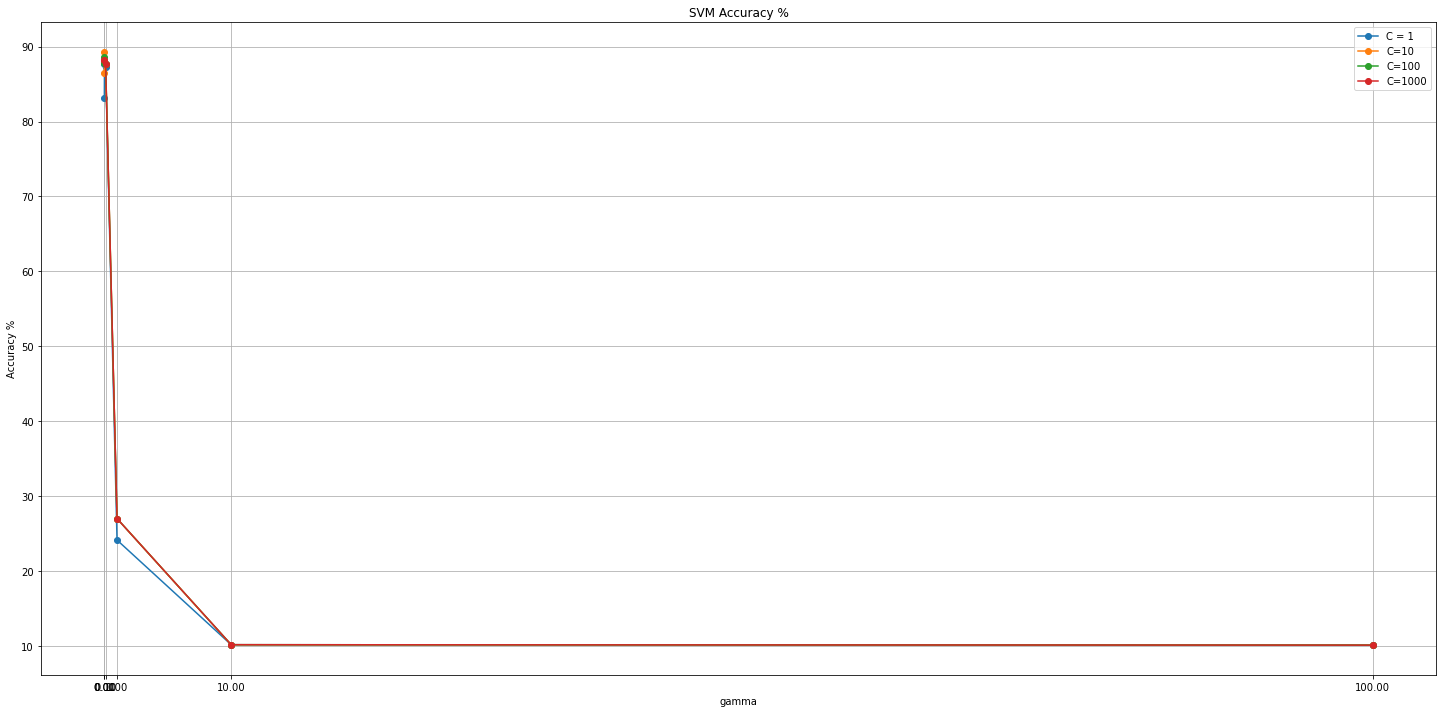

In [48]:
#plot the accuracy rate for each parameter combination
plt.figure(figsize = (25,12))
plt.plot(svm_param_grid['gamma'], svm_accuracy[0], marker='o')
plt.plot(svm_param_grid['gamma'], svm_accuracy[1],  marker='o')
plt.plot(svm_param_grid['gamma'], svm_accuracy[2], marker='o')
plt.plot(svm_param_grid['gamma'], svm_accuracy[3],  marker='o')
plt.xlabel('gamma')
plt.ylabel(ylabel='Accuracy %')
plt.title('SVM Accuracy %')
plt.xticks(svm_param_grid['gamma'])
plt.legend(["C = 1", "C=10", "C=100", "C=1000"])
plt.grid(True)

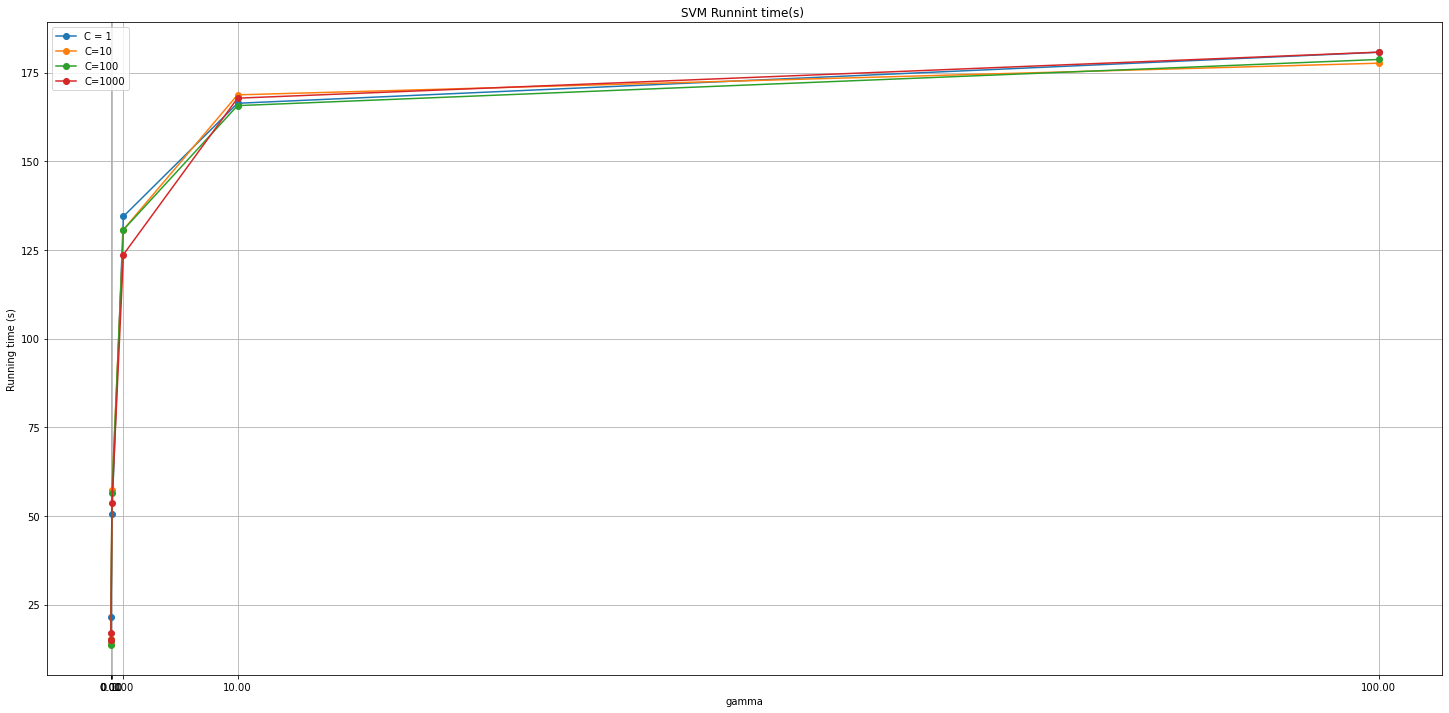

In [57]:
#plot the running time for each parameter combination
plt.figure(figsize = (25,12))
plt.plot(svm_param_grid['gamma'], svm_running_time[0], marker='o')
plt.plot(svm_param_grid['gamma'], svm_running_time[1],  marker='o')
plt.plot(svm_param_grid['gamma'], svm_running_time[2], marker='o')
plt.plot(svm_param_grid['gamma'], svm_running_time[3],  marker='o')
plt.xlabel('gamma')
plt.ylabel(ylabel='Running time (s)')
plt.title('SVM Runnint time(s) ')
plt.xticks(svm_param_grid['gamma'])
plt.legend(["C = 1", "C=10", "C=100", "C=1000"])
plt.grid(True)

In [49]:
#build the final model for svm with its best_parameters
svm = svm_grid_search.best_estimator_

# 3.3 Classifier - Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

#build parameter grid for logistic regression gridsearch, parameters are C for Regularization parameter penalty for regularisation methods
lr_param_grid = {'C': [0.001, 0.01, 1, 10, 100],'penalty': ['l1', 'l2', 'none']}

#Fine-tune hyper-parameters using grid search with logistic regression, using 10-fold cross validation
lr_grid_search = GridSearchCV(LogisticRegression(max_iter = 500, multi_class = 'ovr', solver = 'saga'), lr_param_grid, cv=10)
lr_grid_search.fit(X_train_pca, y_train)

#inspect the grid search cross_validation result
lr_gc_df = pd.DataFrame(lr_grid_search.cv_results_)
lr_gc_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,6.057385,0.141873,0.001474,0.000489,0.001,...,0.694333,0.684333,0.691833,0.005058,15
1,5.461843,0.449867,0.001915,0.001080,0.001,...,0.786333,0.787333,0.790567,0.004931,14
2,133.874529,5.991703,0.001578,0.000415,0.001,...,0.845333,0.847333,0.847333,0.005764,6
3,8.340036,0.881695,0.001429,0.000487,0.01,...,0.787333,0.791333,0.792633,0.005137,13
4,7.696432,0.162648,0.001519,0.000466,0.01,...,0.828333,0.827667,0.830800,0.004602,12


In [24]:
#print out the best parameters combination
print("Best parameters: {}".format(lr_grid_search.best_params_))

Best parameters: {'C': 1, 'penalty': 'l1'}


In [50]:
#To inspect the accuracy and running time of each parameter combination
lr_accuracy = []
lr_running_time = []
m = 0
#use for loop to iterate all Cs parameters
for i in range(len(lr_param_grid['C'])):
    mean_score = []
    mean_time = []
    #and nested another for loop to iterate penalty and to append the accuracy score and running time from each p type
    for j in range(len(lr_param_grid['penalty'])):
        mean_score.append(lr_grid_search.cv_results_['mean_test_score'][m]*100)
        mean_time.append(lr_grid_search.cv_results_['mean_fit_time'][m]
                        +lr_grid_search.cv_results_['mean_score_time'][m])
        m = m+1
    lr_accuracy.append(mean_score)
    lr_running_time.append(mean_time)

#transpose the accurracy and time array for ploting graph purpose
lr_accuracy = np.array(lr_accuracy).T
lr_time = np.array(lr_running_time).T

In [51]:
#inspect the accuracy and running time for each combination in logistic regression
print(lr_accuracy)
print(lr_running_time)

[[69.18333333 79.26333333 84.82333333 84.73       84.74      ]
 [79.05666667 83.08       84.78333333 84.73666667 84.73333333]
 [84.73333333 84.73333333 84.73       84.73333333 84.73666667]]
[[6.058859252929687, 5.463758563995362, 133.87610726356505], [8.341465020179749, 7.697950601577759, 130.7657606124878], [122.46991517543792, 88.39948670864105, 127.66145997047424], [164.359290933609, 126.16255888938905, 127.16302297115325], [169.34025883674622, 127.040141248703, 127.01625967025757]]


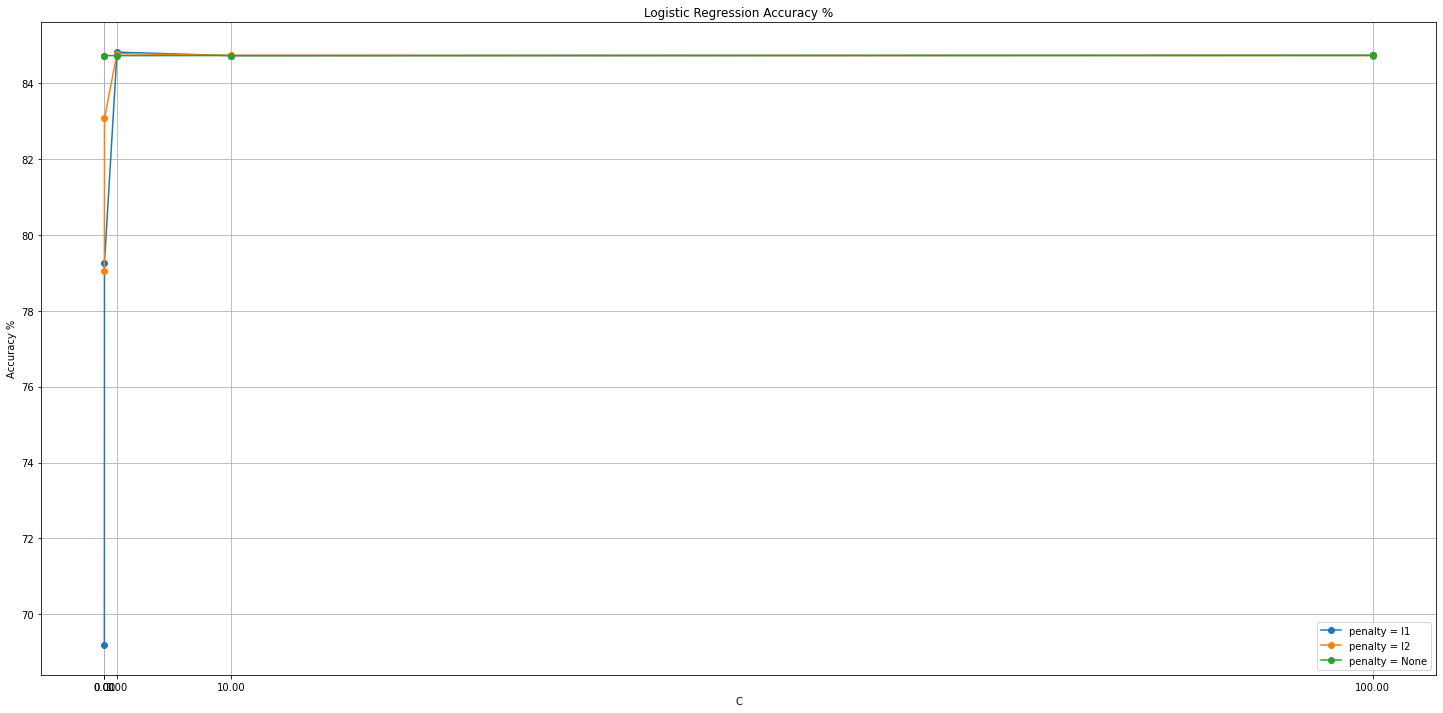

In [52]:
#plot the accuracy rate for each parameter combination
plt.figure(figsize = (25,12))
plt.plot(lr_param_grid['C'], lr_accuracy[0], marker='o')
plt.plot(lr_param_grid['C'], lr_accuracy[1],  marker='o')
plt.plot(lr_param_grid['C'], lr_accuracy[2],  marker='o')
plt.xlabel('C')
plt.ylabel(ylabel='Accuracy %')
plt.title('Logistic Regression Accuracy %')
plt.xticks(lr_param_grid['C'])
plt.legend(["penalty = l1","penalty = l2","penalty = None"])
plt.grid(True)

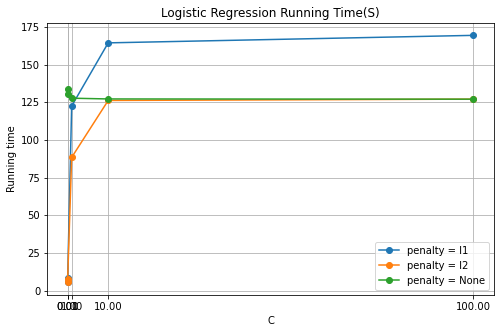

In [55]:
#plot the running time for each parameter combination
plt.figure(figsize = (8,5))

plt.plot(lr_param_grid['C'], lr_time[0], marker='o')
plt.plot(lr_param_grid['C'], lr_time[1],  marker='o')
plt.plot(lr_param_grid['C'], lr_time[2], marker='o')


plt.xlabel('C')
plt.ylabel(ylabel='Running time')
plt.title('Logistic Regression Running Time(S)')

plt.xticks(lr_param_grid['C'])
plt.legend(["penalty = l1","penalty = l2","penalty = None"])
plt.grid(True)

In [29]:
#build the final model for logistic regression with its best_parameters
lr = lr_grid_search.best_estimator_

# 3.4 Ensembles

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

#build parameter grid for Gradient Boosting Classifier gridsearch, parameters number of estimators and maximum depth for the tree
gb_param_grid = {'n_estimators':[30,80],'max_depth':[8, 15, 50]}

#Fine-tune hyper-parameters using grid search with gradient boosting classifier, using 10-fold cross validation
gb_grid_search = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=10)
gb_grid_search.fit(X_train_pca, y_train)

#inspect the grid search cross_validation result
gb_grid_search.cv_results_

{'mean_fit_time': array([ 837.67814324, 2251.00955925, 1479.37441216, 3908.00008805,
        3573.32516067, 9567.62164495]),
 'std_fit_time': array([  2.44954107,  31.69683519,  10.59073901,   8.74755246,
        123.92464392, 344.11060942]),
 'mean_score_time': array([0.03226376, 0.08056512, 0.06492081, 0.18605878, 0.20583038,
        0.65773509]),
 'std_score_time': array([0.00088915, 0.0026617 , 0.00169947, 0.00223826, 0.01128113,
        0.21579523]),
 'param_max_depth': masked_array(data=[8, 8, 15, 15, 50, 50],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[30, 80, 30, 80, 30, 80],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 8, 'n_estimators': 30},
  {'max_depth': 8, 'n_estimators': 80},
  {'max_depth': 15, 'n_estimators': 30},
  {'max_depth': 15, 'n_estimators': 80},
  {'max_d

In [120]:
#print out the best parameters combination
print("Best parameters: {}".format(gb_grid_search.best_params_))

Best parameters: {'max_depth': 8, 'n_estimators': 80}


In [121]:
#calculate and inspect the accuracy rate and running time for each parameter's combination
gb_accuracy = []
gb_running_time = []
m = 0
#use for loop to iterate all max_depth parameters
for i in range(len(gb_param_grid['max_depth'])):
    mean_score = []
    mean_time = []
     #and nested another for loop to iterate n_estimators and to append the accuracy score and running time from each p type
    for j in range(len(gb_param_grid['n_estimators'])):
        mean_score.append(gb_grid_search.cv_results_['mean_test_score'][m]*100)
        mean_time.append(gb_grid_search.cv_results_['mean_fit_time'][m]
                        +gb_grid_search.cv_results_['mean_score_time'][m])
        m = m+1
    gb_accuracy.append(mean_score)
    gb_running_time.append(mean_time)
#transpose the accurracy array for ploting graph purpose        
gb_accuracy = np.array(gb_accuracy).T
gb_time = np.array(gb_running_time)

In [122]:
print(gb_accuracy)
print(gb_running_time)

[[84.54666667 82.92666667 75.09666667]
 [85.86666667 85.19666667 75.32333333]]
[[837.7104069948197, 2251.0901243686676], [1479.4393329620361, 3908.1861468315124], [3573.5309910535816, 9568.279380035401]]


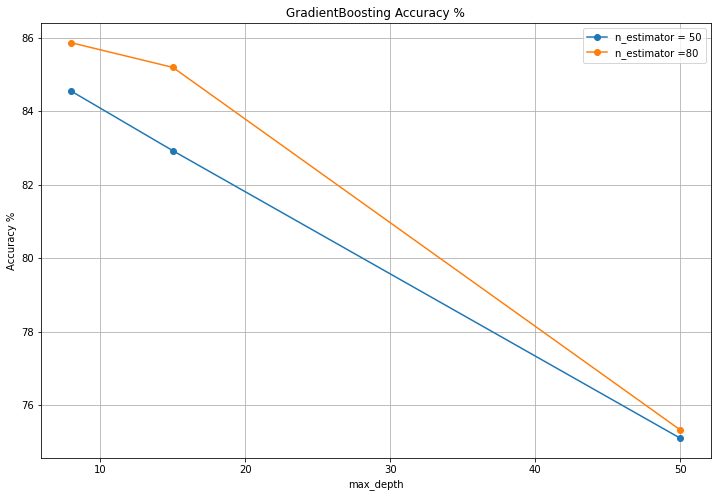

In [123]:
#plot the accuracy rate graph
plt.figure(figsize = (12,8))
plt.plot(gb_param_grid['max_depth'], gb_accuracy[0], marker='o')
plt.plot(gb_param_grid['max_depth'], gb_accuracy[1],  marker='o')

plt.xlabel('max_depth')
plt.ylabel(ylabel='Accuracy %')
plt.title('GradientBoosting Accuracy %')
plt.legend(["n_estimator = 50", "n_estimator =80"])
plt.grid(True)

In [124]:
#build the final model for gradient boosting with its best_parameters
gb = gb_grid_search.best_estimator_

# 4. Classifier Comparison

In [20]:
from time import time

#split the train dataset into train set and validation set for performance evaluation
from sklearn.model_selection import train_test_split
X_train_comp, X_validation, y_train_comp, y_validation = train_test_split(X_train_pca, y_train,random_state=42)

In [127]:
# using the validation set to check the accuracy and running time performance for each classifier
start_time = time()
knn.fit(X_train_comp, y_train_comp)
print("KNN_Best: Accuracy %.2f%%" %(knn.score(X_validation, y_validation)*100))
print("KNN_RunningTime: %.2fs\n" % (time() - start_time))

start_time = time()
svm.fit(X_train_comp, y_train_comp)
print("SVM_Best: Accuracy %.2f%%" %(svm.score(X_validation, y_validation)*100))
print("SVM_RunningTime: %.2fs\n" % (time() - start_time))

import warnings
warnings.filterwarnings("ignore")
start_time = time()
lr.fit(X_train_comp, y_train_comp)
print("LinearRegression_Best: Accuracy %.2f%%" %(lr.score(X_validation, y_validation)*100))
print("LinearRegression_RunningTime: %.2fs\n" % (time() - start_time))

start_time = time()
gb.fit(X_train_comp, y_train_comp)
print("GradientBossting_Best: Accuracy %.2f%%" %(gb.score(X_validation, y_validation)*100))
print("GradientBossting_RunningTime: %.2fs\n" % (time() - start_time))

KNN_Best: Accuracy 85.12%
KNN_RunningTime: 22.86s

SVM_Best: Accuracy 88.93%
SVM_RunningTime: 13.49s

LinearRegression_Best: Accuracy 84.71%
LinearRegression_RunningTime: 114.76s

GradientBossting_Best: Accuracy 85.65%
GradientBossting_RunningTime: 1879.28s



In [22]:
#inspect the classification_report for validation set in knn
from sklearn import metrics
predicted = knn.predict(X_validation)
print(metrics.classification_report(y_validation, predicted))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       735
           1       1.00      0.98      0.99       760
           2       0.80      0.85      0.82       770
           3       0.92      0.90      0.91       755
           4       0.80      0.81      0.81       707
           5       1.00      0.90      0.95       729
           6       0.79      0.70      0.74       769
           7       0.91      0.97      0.94       765
           8       0.98      0.96      0.97       763
           9       0.94      0.97      0.96       747

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.89      7500
weighted avg       0.90      0.90      0.90      7500



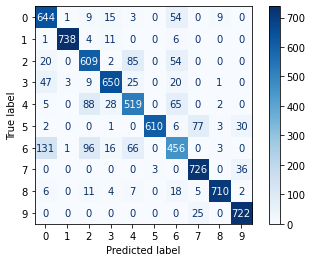

In [133]:
#inspect the confusion_matrix for validation seet in knn
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn, X_validation, y_validation, cmap = 'Blues')
plt.show()

In [138]:
#inspect the classification_report for validation set in svm
from sklearn import metrics
predicted = svm.predict(X_validation)
print(metrics.classification_report(y_validation, predicted))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       735
           1       1.00      0.97      0.98       760
           2       0.81      0.83      0.82       770
           3       0.87      0.89      0.88       755
           4       0.80      0.82      0.81       707
           5       0.97      0.96      0.96       729
           6       0.75      0.68      0.72       769
           7       0.94      0.95      0.95       765
           8       0.97      0.97      0.97       763
           9       0.97      0.96      0.96       747

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



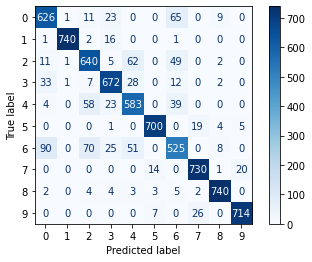

In [132]:
#inspect the confusion_matrix for validation set in svm
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svm, X_validation, y_validation, cmap = 'Blues')
plt.show()

In [139]:
#inspect the classification_report for validation set in logistic regression model
from sklearn import metrics
predicted = lr.predict(X_validation)
print(metrics.classification_report(y_validation, predicted))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       735
           1       0.97      0.97      0.97       760
           2       0.74      0.75      0.75       770
           3       0.83      0.88      0.85       755
           4       0.73      0.76      0.74       707
           5       0.93      0.93      0.93       729
           6       0.66      0.58      0.62       769
           7       0.91      0.92      0.91       765
           8       0.94      0.94      0.94       763
           9       0.94      0.94      0.94       747

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500



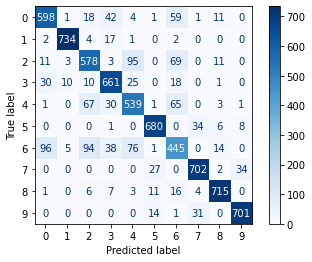

In [134]:
#inspect the confusion_matrix for validation set in logistic regression model
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_validation, y_validation, cmap = 'Blues')
plt.show()

In [137]:
#inspect the classification_report for validation set in logistic gradient boosting model
from sklearn import metrics
predicted = gb.predict(X_validation)
print(metrics.classification_report(y_validation, predicted))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       735
           1       0.99      0.96      0.98       760
           2       0.77      0.79      0.78       770
           3       0.85      0.88      0.86       755
           4       0.75      0.77      0.76       707
           5       0.94      0.91      0.92       729
           6       0.70      0.61      0.65       769
           7       0.92      0.91      0.91       765
           8       0.94      0.94      0.94       763
           9       0.91      0.96      0.94       747

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



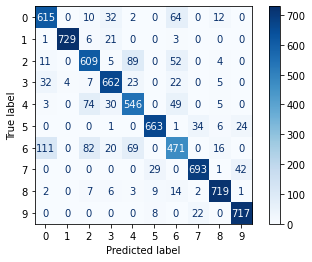

In [135]:
#inspect the confusion_matrix for validation set in gradient boosting model
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gb, X_validation, y_validation, cmap = 'Blues')
plt.show()

# 5. KNN, Logistic Regression, Gradient Boosting Final Model with Best Parameters

In [18]:
#using n_components = 0.96 to build the final model
pca = PCA(n_components = 0.96)
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

#import KNN classifier from sklearn to build the final knn model
from sklearn.neighbors import KNeighborsClassifier
start_time = time()
# after comparisons, build the final a KNN classifier with best parameters when n_neighbors = 5, p -1
final_knn_model = KNeighborsClassifier(n_neighbors = 5, p=1)
final_knn_model.fit(X_train_pca, y_train)

# build the prediction result from the final model for test dataset into a csv file
output = final_knn_model.predict(X_test_pca)
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('D:/USYD/COMP 5318/Assignment/Assignment1/Assignment1/Output/knn_test_output.csv', sep=",", float_format='%d', index_label="id")
print("KNN_RunningTime: %.2fs\n" % (time() - start_time))


SVM_RunningTime: 24.08s



In [20]:
#import logistic regression(lr) classifier from sklearn to build the final lr model
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

start_time = time()
# after comparisons, build the final classification model using Logistic Regression when penalty = l1, C = 1
final_lr_model = LogisticRegression(penalty = 'l1', C = 1, max_iter = 500, multi_class = 'ovr', solver = 'saga')
final_lr_model.fit(X_train_pca, y_train)

# build the prediction result from the final model for test dataset into a csv file
output = final_lr_model.predict(X_test_pca)
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('D:/USYD/COMP 5318/Assignment/Assignment1/Assignment1/Output/lr_test_output.csv', sep=",", float_format='%d', index_label="id")
print("Logistic Regression_RunningTime: %.2fs\n" % (time() - start_time))

Logistic Regression_RunningTime: 169.65s



In [21]:
#import gradient boosting(gb) classifier from sklearn to build the final gb model
from sklearn.ensemble import GradientBoostingClassifier
start_time = time()
# after comparisons, build the final classification model using gradient boosting with best parameters when max_depth = 8, n_estimators = 80
final_gb_model = GradientBoostingClassifier(n_estimators = 80, max_depth = 8)
final_gb_model.fit(X_train_pca, y_train)

# build the prediction result from the final model for test dataset into a csv file
output = final_gb_model.predict(X_test_pca)
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('D:/USYD/COMP 5318/Assignment/Assignment1/Assignment1/Output/fb_test_output.csv', sep=",", float_format='%d', index_label="id")
print("KNN_RunningTime: %.2fs\n" % (time() - start_time))

KNN_RunningTime: 3038.10s



# 7. Final and chosen Model - SVM

In [9]:
#using n_components = 0.96 to build the final model
pca = PCA(n_components = 0.96)
#fit the feature train data under PCA
pca.fit(X_train_norm)
#transform feature train data and test data after normalisation and PCA fit
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [10]:
#import SVC from sklearn library to build svm model
from sklearn.svm import SVC
#calculate the running time from the start
start_time = time()
# after comparisons, build the final classification model using SVC with best parameters when C = 10, gamma =0.01
final_model = SVC(C=10, gamma =0.01)
final_model.fit(X_train_pca, y_train)

SVC(C=10, gamma=0.01)

In [11]:
# build the prediction result from the final svm model 
output = final_model.predict(X_test_pca)

#transfer the prediction output into a pandas dataframe
output_df = pd.DataFrame(output, columns = ['label'])

In [12]:
#savetest dataset label dataframe into a csv file
output_df.to_csv('./Output/test_output.csv', sep=",", float_format='%d', index_label="id")

#calculate the final running time use ending time minus starting time
print("SVM_RunningTime: %.2fs\n" % (time() - start_time))

SVM_RunningTime: 23.27s



In [13]:
#read the new final output file for test dataset
df = pd.read_csv('./Output/test_output.csv')

In [14]:
#inspect the test_output csv file
df.head()

,id,label
0,0,1
1,1,1
2,2,1
3,3,0
4,4,3


# 8. Hardware and software specifications of the computer

Processor: 11th Gen Intel(R) Core(TM)

CPU: i7-11700 @ 2.50GHz   2.50 GHz

Installed RAM: 32.0 GB (31.8 GB usable)

System: Windows 11 Home

System type: 64-bit operating system, x64-based processor

Software: Jupyter Notebook